# 1. Library Importation

In [1]:
# استيراد المكتبات
!pip install mediapipe

import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is

2025-04-24 02:51:45.361377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745463105.641570      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745463105.715350      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Skeletal Point Extraction Function

In [2]:
# إعداد MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# دالة لاستخراج الـ landmarks مع الـ scaling وتوسيط
def extract_and_scale_landmarks(image_path, img_size=400, padding=50):
    image = cv2.imread(image_path)
    if image is None or image.size == 0:
        print(f"Failed to load or empty image: {image_path}")
        return np.zeros(63)
    
    h, w, _ = image.shape
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if not results.multi_hand_landmarks:
        print(f"No hands detected in {image_path}")
        return np.zeros(63)
    
    landmarks = results.multi_hand_landmarks[0]
    handedness = "Right"
    if results.multi_handedness and len(results.multi_handedness) > 0:
        handedness = results.multi_handedness[0].classification[0].label
    
    # التأكد إن اليد يمين (قلب الصورة لو اليد شمال)
    if handedness == "Left":
        image = cv2.flip(image, 1)  # قلب أفقي
        for landmark in landmarks.landmark:
            landmark.x = 1 - landmark.x  # تعديل إحداثيات x بعد القلب
    
    # استخراج إحداثيات الـ landmarks بالبكسل
    points = [(int(l.x * w), int(l.y * h)) for l in landmarks.landmark]
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    
    hand_width, hand_height = x_max - x_min, y_max - y_min
    if hand_width < 10 or hand_height < 10:
        print(f"Hand too small in {image_path}: width={hand_width}, height={hand_height}")
        return np.zeros(63)
    
    x_min, y_min = max(0, x_min - padding), max(0, y_min - padding)
    x_max, y_max = min(w, x_max + padding), min(h, y_max + padding)
    
    hand_width, hand_height = x_max - x_min, y_max - y_min
    scale = (img_size - 2 * padding) / max(hand_width, hand_height)
    offset_x = (img_size - hand_width * scale) / 2
    offset_y = (img_size - hand_height * scale) / 2
    
    scaled_points = [
        (int((x - x_min) * scale + offset_x), int((y - y_min) * scale + offset_y))
        for x, y in points
    ]
    
    normalized_points = []
    for x, y in scaled_points:
        normalized_points.extend([x / img_size, y / img_size, 0.0])
    
    return np.array(normalized_points)

# 3. Data Upload and Processing

In [3]:
# مسار البيانات على Kaggle
data_dir = '/kaggle/input/synthetic-asl-alphabet/Train_Alphabet'  # استبدل بالمسار الصحيح

# إعداد البيانات
X = []  # النقاط
y = []  # التسميات
labels = sorted(os.listdir(data_dir))  # A, B, ..., Z, Blank

# استبعاد فئة "Blank"
labels = [label for label in labels if label != 'Blank']

label_map = {label: idx for idx, label in enumerate(labels)}

# التأكد من عدد الفئات
print(f"Labels found: {labels}")
print(f"Number of classes: {len(labels)}")  # المفروض يكون 27 (A-Z + Blank)

# استخراج الـ landmarks من الصور مع الـ scaling وتوسيط
for label in tqdm(labels, desc="Processing labels"):
    label_dir = os.path.join(data_dir, label)
    for image_name in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_name)
        landmarks = extract_and_scale_landmarks(image_path, img_size=400, padding=50)
        X.append(landmarks)
        y.append(label_map[label])

# تحويل إلى مصفوفات NumPy
X = np.array(X)  # شكلها: (عدد الصور, 63)
y = np.array(y)  # شكلها: (عدد الصور,)
y = to_categorical(y, num_classes=len(labels))  # تحويل إلى One-Hot Encoding (27 فئة)

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Labels found: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Number of classes: 26


Processing labels:   0%|          | 0/26 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
W0000 00:00:1745463121.420609      64 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745463121.461309      64 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745463121.654024      65 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/A/c4b1dd3e-dd5d-4791-9559-84aecdf2e681.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/A/27089cc0-a43e-4330-89bd-643b3994ac05.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/A/5c42d730-652a-4da6-8c62-05cd76d2f4cf.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/A/af5eed73-54a4-4d09-b2da-4fd051a6a48b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/A/d7f8d0f1-1fdf-4fbc-bf26-401a862ebf75.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/A/f2540d5e-496b-4ab5-a33f-976b516ace00.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/A/be27bd4a-dd54-490f-8e1e-ed684f9505dc.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/A/7275114d-6349-4524-a0d4-9d35216acf15.rgb_0000.png


Processing labels:   4%|▍         | 1/26 [00:53<22:15, 53.42s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/B/eb86da47-823d-43f4-a86d-54ce0b170e9c.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/B/8938e4d0-b5f0-4996-8f02-73d1e3a8439a.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/B/f445f133-3589-409c-b2e6-65eff834ebea.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/B/bb8a8903-edde-4444-abf2-0320bfe5b2ff.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/B/714e09bf-ef3a-4c9d-916a-136e1a3f9cfe.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/B/a0bb505b-f797-4806-a45d-74a78662c73c.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/B/ef340cd0-7244-498c-bf40-632d73d925aa.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/B/c23f3031-07d9-45f5-9ad7-9ebe16e93d69.rgb_0000.png


Processing labels:   8%|▊         | 2/26 [01:46<21:19, 53.30s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/C/e74d5a59-9ead-419e-911a-127e95de95aa.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/C/c182cdaa-0f90-43d9-8598-500e5618b3f5.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/C/468f4b0e-cb5d-48ea-b1e0-c3460d15c876.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/C/54e7250c-e0d7-4d83-a1b9-c9710beef00b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/C/3c4360fb-00ac-470b-99bc-a8871c1018e9.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/C/98f20c01-fa9e-49a4-8cec-e8683ea087db.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/C/52a99f52-52c1-49d5-8237-bd196450c1d4.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/C/b2438baf-fa68-4ad7-8540-ec44d1b3d8b3.rgb_0000.png


Processing labels:  12%|█▏        | 3/26 [02:40<20:30, 53.49s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/D/fd9c8bbe-177d-4743-8a2e-96c0ff4560cd.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/D/f63cacce-1f40-4188-8483-8e70b6b3b316.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/D/11c372f6-cf54-483e-bf52-c6cfd945e4b2.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/D/d9c4a959-37ab-45ae-8039-3b063fae352f.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/D/dfbda16f-a38a-4389-8d5f-a619828c0137.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/D/8baf07c4-4575-49c9-be2a-c1a02bc8a37b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/D/fc251d08-d8f4-41f6-a1d5-0a411f4b0fd2.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/D/6ca5cd12-3b13-4993-b991-56c606e8b168.rgb_0000.png


Processing labels:  15%|█▌        | 4/26 [03:32<19:25, 52.99s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/E/5c9dbe68-6785-4bae-9b7a-2322ad808bb8.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/E/758de7cb-1cb1-466f-a568-a293f1e93ff9.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/E/39405a20-cae4-4913-a451-187a49a08bce.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/E/214bc5d2-f0c4-4d6d-8279-32035bcfb4b7.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/E/37bb4d4e-3806-4560-873f-b6291e689618.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/E/45bde8d9-aa39-4769-b238-511a7adb0749.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/E/ddaebdb0-fd1a-4f51-a62c-8244ce17d3d9.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/E/5bb5a1ad-6037-40ca-8ddc-c9840ac56c7e.rgb_0000.png


Processing labels:  19%|█▉        | 5/26 [04:23<18:18, 52.32s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/E/2d4fc25c-fd49-43f4-b1fb-3f65479e8dec.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/F/154031e3-5221-4022-9cba-9200aa15849b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/F/d4be5562-096e-4801-af16-9e8e30bdbf5b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/F/a0c15493-ef75-42c1-8fc0-620c8a33ea22.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/F/062d9b1d-24c9-488a-901b-e5d417fe2775.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/F/2f1a3518-377b-4360-9a05-32ca6dbfcc70.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/F/8856f395-6cfb-4210-b486-f131dbaf192e.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/F/dce7c55d-008d-4930-bead-7aa788146a47.rgb_0000.png


Processing labels:  23%|██▎       | 6/26 [05:16<17:28, 52.42s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/F/f352ae11-8120-4fed-89ce-b71ab85d661c.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/F/5ce2ccb4-e53f-4e93-b1b5-d0810fb3d905.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/G/6b42e015-f97f-4550-8afe-5b996a995adf.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/G/7b93ae94-ed8c-4a2d-a941-112313b0f0c6.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/G/51dc6876-3a6e-4540-922c-4c2a363bf778.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/G/40b37dec-8509-449d-b262-3fadfac0f1a1.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/G/47577576-bd50-4992-a627-48aa0f6e2849.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/G/10469a69-0813-4538-839f-7066248a4821.rgb_0000.png


Processing labels:  27%|██▋       | 7/26 [06:10<16:44, 52.85s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/G/f87de11e-f42e-4ec6-9de3-330fa9cc68b7.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/H/779b0164-6164-4e69-bd82-abab6913f164.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/H/bc145ed2-54a3-4319-94d3-2d3aa4c50529.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/H/e1ac732c-62ba-43c9-bd74-5d8f8bf4e976.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/H/2f47d7b0-3761-4876-bbcc-78675b262297.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/H/39d53790-ee2a-4775-a6b1-d037600caf91.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/H/b8d6f2c1-f919-4dab-bd16-476a309f0f97.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/H/cfc82cf9-e6a8-44d5-86a9-033fe28da563.rgb_0000.png


Processing labels:  31%|███       | 8/26 [07:04<15:58, 53.25s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/I/ed9962ce-fb0c-432c-823b-afb41ef96141.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/I/5fef5842-103c-4c9b-8fa5-924de6a6f265.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/I/3df27a2a-eb60-42ff-95b0-95e025f73623.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/I/f3de92f1-64bd-4379-8527-510f33b42c62.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/I/6167ef2c-fe96-42d3-a707-07d0a8a4f9f8.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/I/d8e499e6-7057-4b3f-80d7-2e00fb92db23.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/I/d297f212-8013-458c-b154-1a74ed6f7307.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/I/7825fa08-c170-4ac5-9cb0-0e52e182794e.rgb_0000.png


Processing labels:  35%|███▍      | 9/26 [07:57<15:04, 53.18s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/I/9f730c8f-75aa-4f4c-83fc-639137d3c2e1.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/J/c581aef3-0b82-4668-a4cb-d8e4339bc8d8.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/J/9df67abe-6995-40af-a22e-316896f7f7b8.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/J/f1bb9332-93d8-4b5f-bef5-e512381a7cfe.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/J/91b59ba1-ecb0-4c63-a9b5-c11796c69348.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/J/49aad2ea-a0cd-4d27-a786-f04abfb645c5.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/J/67fe3019-3271-4982-855c-74bfc1b43fd9.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/J/2b7730c7-7f09-48ec-9175-76c966c75976.rgb_0000.png


Processing labels:  38%|███▊      | 10/26 [08:51<14:14, 53.40s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/K/a46915ec-ecff-4ab4-8dac-6ba9f769c4af.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/K/06da0c67-c7b2-4d75-8118-1ecfabb82705.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/K/68dcf045-75c8-4cb7-9b3b-95bd89e6a495.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/K/b2ac8c2d-e37d-4beb-8692-5eb23249629b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/K/38727d54-bb84-4f25-bf25-eb099aa6bdf4.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/K/7c4c1e8a-31c0-4d51-82d2-3e88eda47e91.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/K/6ed31b66-328e-425a-bad3-4f2297b49774.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/K/ed07c0c7-7833-4eb7-ba52-fe5dc9b29558.rgb_0000.png


Processing labels:  42%|████▏     | 11/26 [09:44<13:21, 53.43s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/L/80b25e08-8f80-41b4-81c0-d073dcb09c8d.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/L/f2bc9540-57a7-4887-be9e-3e978f22a5ae.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/L/ae9da793-da82-4f65-947e-653b82ee7ac8.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/L/f47f8a38-2410-403c-9511-a5277b0b771e.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/L/9cedf62b-a2ef-4319-9fc5-8824086fbbb5.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/L/fa49468b-4cbf-4420-adc8-1fd53efae07b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/L/57382a16-58c7-469d-a513-2063a146e087.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/L/829db6d9-2ae5-4ef0-98a8-76828c06917b.rgb_0000.png


Processing labels:  46%|████▌     | 12/26 [10:37<12:25, 53.28s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/L/4f3c1fbd-e9a0-49cb-ab9e-148cb58ed5a9.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/M/c29eb250-fe0b-469f-a9d7-bea953b352f1.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/M/550789ac-fb28-4f2f-89df-7ffe0a1e79a7.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/M/9fd31f05-1bbf-40d1-aed1-2ca3b3ee1b1b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/M/348e690d-18f4-4892-9b00-a9a62db8b13f.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/M/e949763b-0609-4b29-be30-5c9b6da44a5c.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/M/910a98b2-e12b-47b2-a881-6f0fed125455.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/M/0e3fde57-e792-421e-abe6-c2259bdf363e.rgb_0000.png


Processing labels:  50%|█████     | 13/26 [11:29<11:28, 52.92s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/M/58213898-6e96-493f-9d0c-d44656a230ab.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/N/414d207d-b68b-4be2-aaec-b94fe25eb6e2.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/N/15b2863a-deb9-462c-824c-d8afd85b8c3d.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/N/8ae372f6-657d-46b8-b48d-76cce1399e6d.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/N/8f2ab8c0-a5d7-47f2-9db5-d391d9caa643.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/N/5ded0710-575a-4acc-a461-18d0e2e87fc0.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/N/ea16d962-8692-4eda-9c59-58eea2a3c2c6.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/N/1a174244-e5b6-48f8-972f-5da585e77aba.rgb_0000.png


Processing labels:  54%|█████▍    | 14/26 [12:22<10:36, 53.04s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/O/a44eb8e5-86d0-4e40-98cd-a8e888b60328.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/O/808e9a27-01db-4f99-aa81-c42dc2a3f856.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/O/923e053a-aae0-469e-91da-cd17c234c913.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/O/399921ca-6fb2-4416-ad90-5a264acbb661.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/O/0555ea8f-7b08-4894-a3aa-c622f317ea6a.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/O/58f92c17-03a3-4162-a690-b346766d38f8.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/O/f228cebf-e1c7-4f2f-a751-1e777f5af699.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/O/78149d1b-b8ce-4822-aabc-4602eeeb7119.rgb_0000.png


Processing labels:  58%|█████▊    | 15/26 [13:15<09:42, 52.96s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/P/95ab26c0-97d6-45c8-91fd-842c07e1d0d5.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/P/3446775c-b3b5-4d52-86ec-8bff2423965f.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/P/1856d1f5-094b-407d-91fc-8e54ab6e7730.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/P/f06fd9eb-0348-4549-aea3-7280e0000b01.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/P/3791633b-5643-40c3-b3dc-4dde016f4abe.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/P/42ad521f-3b26-4dba-a39f-6bfb5d4fd9f7.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/P/7fb1ef9e-783c-4199-bc52-5c9a29394671.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/P/049c3f48-5eeb-4435-b743-ca0ac8cef842.rgb_0000.png


Processing labels:  62%|██████▏   | 16/26 [14:07<08:47, 52.76s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Q/6b3af51c-3f1f-4e7c-9e0c-88ed74fcf863.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Q/9f86c101-ac33-4ca0-af0d-9a03a136bdb1.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Q/6f947c71-e8c9-49ca-99ad-81a10298b039.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Q/b171a762-51a4-45bd-8a54-5a27751ddfa3.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Q/fd0ac4d4-f37d-4e39-adcf-612ff8372260.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Q/612c988f-4025-4b9d-a8f4-32aca56f1a00.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Q/88a438bd-f51a-4484-a05b-975261808ed5.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Q/0790a4d6-93ac-4b25-958a-40b28e925b27.rgb_0000.png


Processing labels:  65%|██████▌   | 17/26 [15:01<07:55, 52.84s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/R/0fd32636-f127-48cf-88a9-9b102b97b395.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/R/fc9f30d0-1ba4-4faa-baa4-b112ea856962.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/R/ae901e8f-07be-4208-8777-62759878d6ff.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/R/216984b2-f1f1-45e6-83e4-84c7b2b2cc69.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/R/62ed6f1e-ba68-4492-a68a-eb2146099031.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/R/ea765beb-b31c-4bc3-819c-25338e988a8e.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/R/9cde1fdc-ccf5-431b-9970-dbce7cddd2d4.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/R/2be02b62-9253-46f0-8380-e59c75c1618b.rgb_0000.png


Processing labels:  69%|██████▉   | 18/26 [15:54<07:04, 53.01s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/S/d964a0f5-bc4b-4c18-88dc-3f32de8f986b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/S/e0177069-6bc3-42d1-8c89-6622bc4dd5e3.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/S/b45b74ef-7e8c-415a-9a59-12f9bcd86df0.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/S/8d4eacdd-ec0a-49da-83c7-bad57c835028.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/S/23de909e-9899-41eb-a433-de7400dcb3c7.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/S/87e84469-e77f-43b2-992e-2553f5d4a6cb.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/S/647e5f69-d391-49cd-b540-830ff3325cc2.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/S/5c2623a6-f817-4df9-8280-d52f85cc55d1.rgb_0000.png


Processing labels:  73%|███████▎  | 19/26 [16:47<06:11, 53.06s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/S/f154c735-7f9a-4187-92b1-941bb01df9b7.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/T/fb5aff12-717a-4183-83b2-a1c6506d23b3.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/T/43e1deb5-4723-461f-9ed8-f24d0527e7ab.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/T/ff180845-5cdd-4f4c-a2af-8aa4ecaac921.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/T/06f8c0d4-6537-4b4e-9446-e1ab5e27e7c2.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/T/bda47340-cef0-4e0e-8c21-2099faa3b4b0.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/T/521beb1f-fb71-44ed-aaf8-978d02d6b239.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/T/ebe3b7b3-956f-45ba-97d0-4bbc1d6b9ed6.rgb_0000.png


Processing labels:  77%|███████▋  | 20/26 [17:41<05:20, 53.39s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/U/bd64bde2-b62b-4a8c-97f9-5d0308ecbf61.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/U/cf08d945-4391-4def-aa48-e43dc75a0ac0.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/U/aa3874fb-f7aa-4482-89e3-33acfc8cde14.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/U/b6960480-cea4-48ac-9e94-c2ab8538e5da.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/U/b3ff123a-5aaf-41ae-a9de-2f1836b4c8e8.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/U/89ca72eb-f6c6-4d3f-ac4e-324be0c1b24b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/U/90251893-840c-4141-9a6e-f04e03ea8ce6.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/U/90e3f9fc-c185-4b0e-85a2-08fc4acd55aa.rgb_0000.png


Processing labels:  81%|████████  | 21/26 [18:35<04:27, 53.55s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/V/038ef4a4-8cd7-4d15-ab47-75f198d06410.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/V/6dfe6247-60db-41cc-b477-92c51afab2aa.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/V/42a95328-197f-49e3-b774-c82b5b2f43be.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/V/33d18274-b8a8-4a05-bd86-3655973fc715.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/V/a0457b49-729d-4495-a323-19521e138a6f.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/V/6605d07b-1b67-463d-b6f2-e728fbf52fcf.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/V/567709a6-e8ae-40a7-a73a-bd110cff8d89.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/V/ab42fc63-42fa-4608-a75a-671929c15ff7.rgb_0000.png


Processing labels:  85%|████████▍ | 22/26 [19:28<03:33, 53.26s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/W/66db44bf-774e-4877-8a9a-5e85c0f00d61.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/W/961e5d98-652e-4a5f-82a3-a41142ee8c8a.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/W/adf32573-078d-4e01-98fc-7b03fea8de40.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/W/d4b593f2-eb2a-4d98-b492-373a963828b0.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/W/60080e2a-c4d2-4323-b795-014ce1ab284e.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/W/4576dc4c-909b-4c28-957f-36f5ce967c5c.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/W/01ab12b4-0599-4d5e-8d59-2343ac1668a0.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/W/9dc8edfa-29b6-48de-a8da-c7f797189ac7.rgb_0000.png


Processing labels:  88%|████████▊ | 23/26 [20:24<02:42, 54.08s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/X/f777deaa-a8ec-47d1-bb6f-32285cdf9da1.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/X/85e41b5f-0a0c-4c90-9a02-ddd80f1c57d8.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/X/89d7632e-ab49-4dfe-a672-4b08a1c907fc.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/X/c0cef7e2-56a5-42be-b999-6ba47adab201.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/X/0d253359-e06b-4945-b2c9-1a695d5f60b6.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/X/64169e9c-813e-4630-be87-5929fdb3f782.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/X/2997e831-9e0a-4b59-98e7-6bbe5dc5c951.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/X/b1ad1a4b-eb0f-4374-a80e-18772c6a46e9.rgb_0000.png


Processing labels:  92%|█████████▏| 24/26 [21:18<01:47, 54.00s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Y/9b6a4640-bd87-46ae-9856-dd55ba24bf39.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Y/59fe9dbb-9235-4697-b2fe-af239aedae5b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Y/86615b21-7801-4890-9bd2-1aaae6096c34.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Y/82790ace-5489-4b1a-9a8d-9f0bb5403229.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Y/66572791-5884-4021-be8a-38105b3f9a06.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Y/d4825b60-f120-43d1-bef0-a8a0dfc91e14.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Y/b0f8c737-14ed-491c-bb5d-929071ae5d38.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Y/b15a530f-a26b-4227-b2e2-dd8205b730ce.rgb_0000.png


Processing labels:  96%|█████████▌| 25/26 [22:11<00:53, 53.68s/it]

No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Y/62dbded7-15b4-4707-9c91-732929d97a1f.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Z/babe4c69-ac90-4525-96b9-15aacfce7abb.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Z/d1119a0d-d531-461a-b9d9-2eb635b5230b.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Z/77906a5d-0fd7-455b-8d3f-28b8894d8cf4.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Z/a9146b19-ddc5-49ba-8b3c-8786fee200f6.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Z/fccf1a39-a476-44bf-a65e-b126cd4cebc2.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Z/8a8f6804-4e59-4b62-826a-1e1e09f8936c.rgb_0000.png
No hands detected in /kaggle/input/synthetic-asl-alphabet/Train_Alphabet/Z/7776036a-90b2-4dca-8ea4-c72c1b9ba876.rgb_0000.png


Processing labels: 100%|██████████| 26/26 [23:03<00:00, 53.22s/it]

Training data shape: (16848, 63)
Validation data shape: (1872, 63)
Test data shape: (4680, 63)


# 4. Build and assemble the model

In [4]:
# بناء النموذج
model = Sequential([
    Dense(128, activation='relu', input_shape=(63,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(labels), activation='softmax')  # 27 فئة (A-Z + Blank)
])

# تجميع النموذج
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-24 03:15:05.729644: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,386 (75.73 KB)

 Trainable params: 19,386 (75.73 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Model Training

In [5]:
# إعداد Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# تدريب النموذج
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping]
)

# تقييم النموذج على بيانات الاختبار
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/150
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1352 - loss: 2.9204 - val_accuracy: 0.6950 - val_loss: 1.1991
Epoch 2/150
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5549 - loss: 1.3294 - val_accuracy: 0.8424 - val_loss: 0.7284
Epoch 3/150
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6915 - loss: 0.9676 - val_accuracy: 0.8424 - val_loss: 0.6002
Epoch 4/150
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7458 - loss: 0.8234 - val_accuracy: 0.8771 - val_loss: 0.5359
Epoch 5/150
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7802 - loss: 0.7336 - val_accuracy: 0.8579 - val_loss: 0.5182
Epoch 6/150
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7985 - loss: 0.6820 - val_accuracy: 0.8819 - val_loss: 0.4662
Epoch 7/150
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8093 - loss: 0.6574 - val_accuracy: 0.8809 - val_loss: 0.4549
Epoch 8/150
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8156 - loss: 0.6294 - val_accu

# 6. Visualization of performance

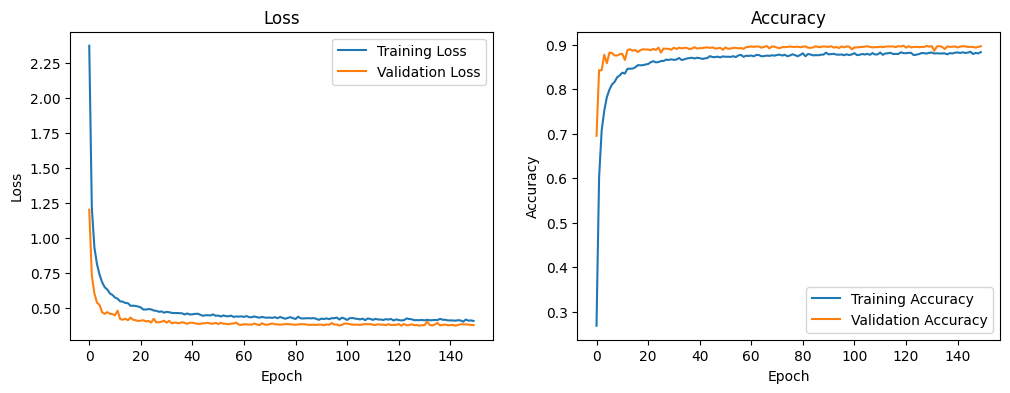

In [6]:
# رسم الخسارة والدقة
plt.figure(figsize=(12, 4))

# الخسارة
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# الدقة
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


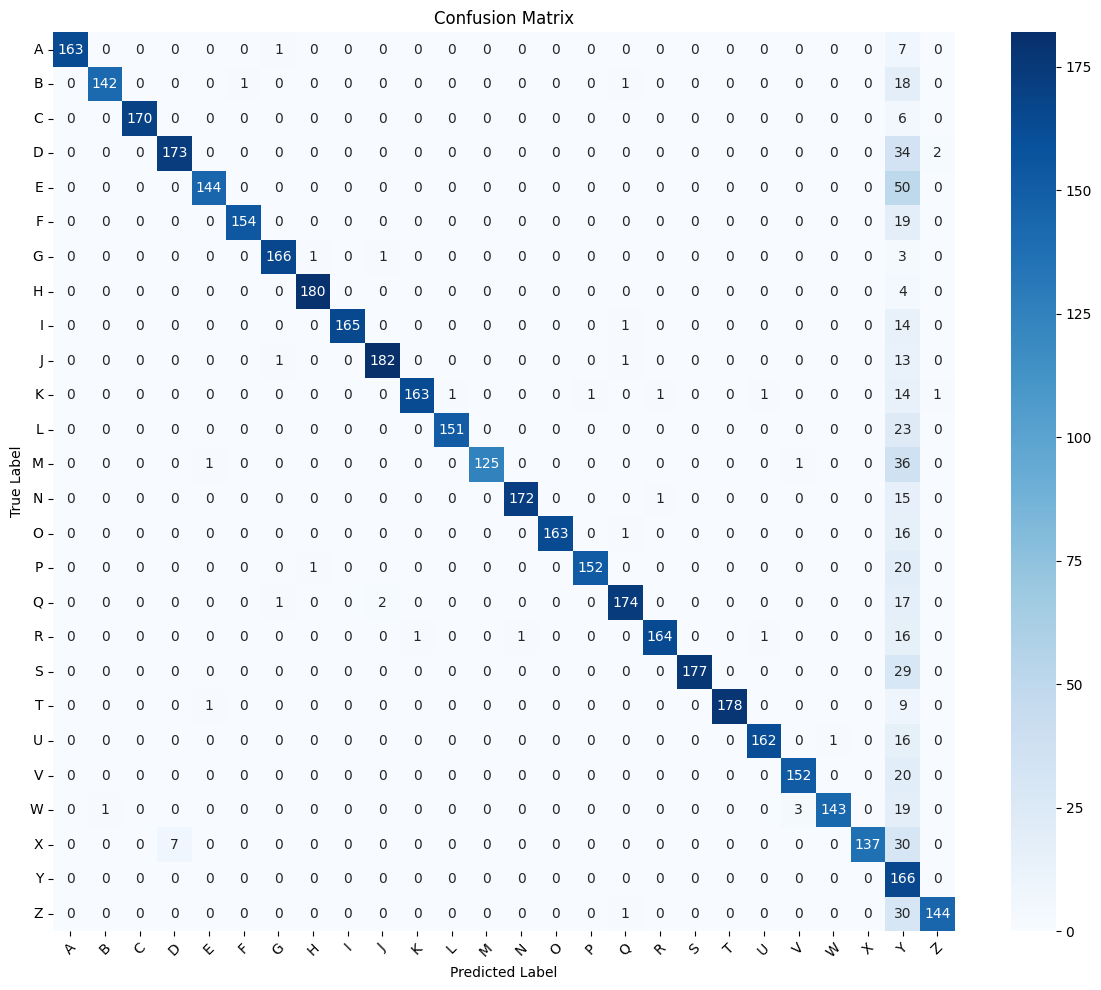


Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.95      0.98       171
           B       0.99      0.88      0.93       162
           C       1.00      0.97      0.98       176
           D       0.96      0.83      0.89       209
           E       0.99      0.74      0.85       194
           F       0.99      0.89      0.94       173
           G       0.98      0.97      0.98       171
           H       0.99      0.98      0.98       184
           I       1.00      0.92      0.96       180
           J       0.98      0.92      0.95       197
           K       0.99      0.90      0.94       182
           L       0.99      0.87      0.93       174
           M       1.00      0.77      0.87       163
           N       0.99      0.91      0.95       188
           O       1.00      0.91      0.95       180
           P       0.99      0.88      0.93       173
           Q       0.97      0.90      0.93       194
   

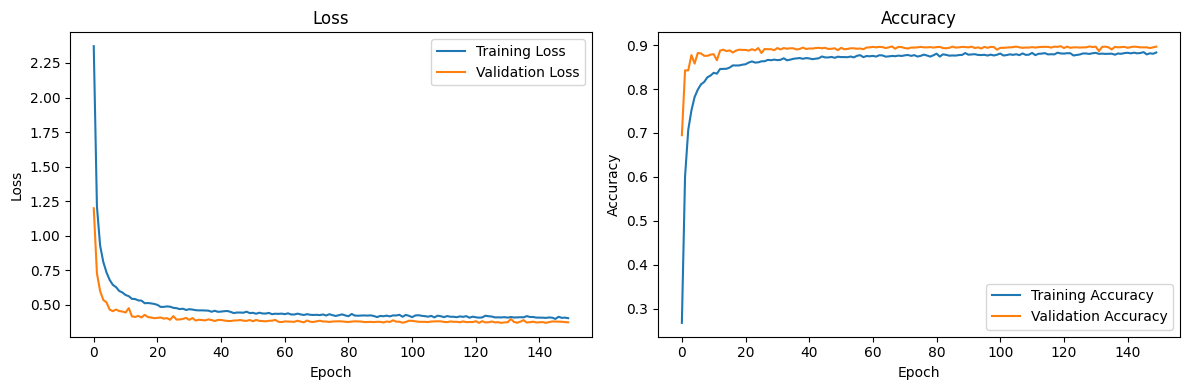

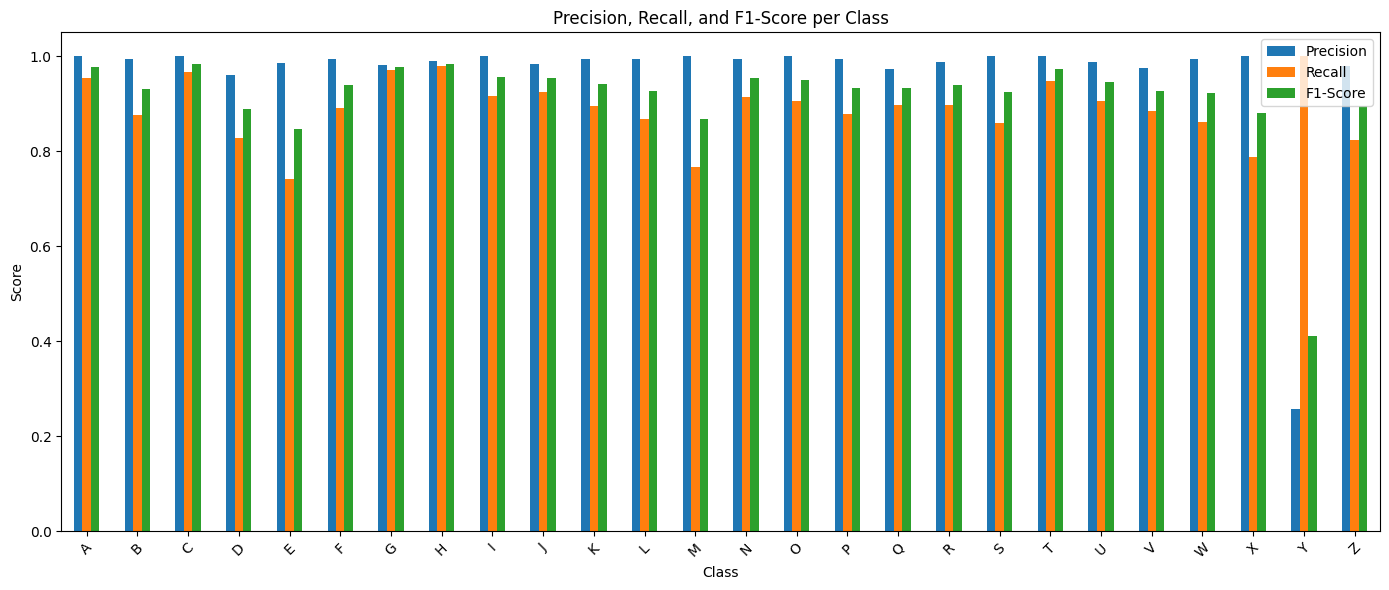

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# التنبؤ على بيانات الاختبار
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# رسم Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
class_report = classification_report(y_test_classes, y_pred_classes, target_names=labels)
print(class_report)

# 3. رسم الخسارة والدقة أثناء التدريب
plt.figure(figsize=(12, 4))

# الخسارة
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# الدقة
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 4. رسم Precision, Recall, F1-Score لكل فئة
from sklearn.metrics import precision_recall_fscore_support

# حساب Precision, Recall, F1-Score لكل فئة
precision, recall, f1, _ = precision_recall_fscore_support(y_test_classes, y_pred_classes, average=None)

# إعداد البيانات للرسم
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=labels)

# رسم الـ Metrics
metrics_df.plot(kind='bar', figsize=(14, 6))
plt.title('Precision, Recall, and F1-Score per Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 7. Save Model

In [8]:
model.save('/kaggle/working/english_sign_language_model.h5')
print("Model saved to /kaggle/working/sign_language_model.h5")

Model saved to /kaggle/working/sign_language_model.h5
